In [383]:
# Importing the libraries

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import gzip
from io import BytesIO
import pycountry
import plotly.express as px
from scipy.stats import normaltest
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import praw
import pandas as pd
from textblob import TextBlob
from statsmodels.formula.api import ols
from scipy.stats import kruskal
from scipy.stats import wilcoxon
from dotenv import load_dotenv
from os import getenv
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

Create the Dataset

In [313]:
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/EI_ISBU_Q?format=TSV&compressed=true' # The url of the data
headers = {'Accept-Encoding': 'gzip'} # This is important to get the gzip file
response = requests.get(url, headers=headers) # Get the data from the url

buf = BytesIO(response.content) # Read the gzip file
f = gzip.GzipFile(fileobj=buf) # Unzip the gzip file
content = f.read() # Read the unzipped file

df = pd.read_csv(BytesIO(content), sep='\t') # Read the unzipped file as a dataframe
print(df.head())


  freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD 1980-Q1  1980-Q2  1980-Q3   \
0                       Q,I2015,NSA,IS-EPI,F,AL       :        :        :    
1                       Q,I2015,NSA,IS-EPI,F,AT       :        :        :    
2                       Q,I2015,NSA,IS-EPI,F,BE       :        :        :    
3                       Q,I2015,NSA,IS-EPI,F,BG       :        :        :    
4                       Q,I2015,NSA,IS-EPI,F,CH       :        :        :    

  1980-Q4  1981-Q1  1981-Q2  1981-Q3  1981-Q4  1982-Q1   ... 2020-Q4   \
0       :        :        :        :        :        :   ...   119.4    
1       :        :        :        :        :        :   ...   116.9    
2       :        :        :        :        :        :   ...   108.2    
3       :        :        :        :        :        :   ...   103.3    
4       :        :        :        :        :        :   ...  102.1 e   

  2021-Q1  2021-Q2  2021-Q3  2021-Q4  2022-Q1  2022-Q2  2022-Q3  2022-Q4   \
0   123.7    12

In [314]:
# Melt the dataframe so all the Quarters are in one column
df = pd.melt(df, id_vars=['freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD'], var_name='Quarter', value_name='Value')

# The column freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD is split into 6 columns
df[['freq','unit','s_adj','indic','nace_r2','geo\TIME_PERIOD']] = df['freq,unit,s_adj,indic,nace_r2,geo\\TIME_PERIOD'].str.split(',', expand=True)

# Drop the column freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD and move Quarter and Value to the back
df = df.drop(['freq,unit,s_adj,indic,nace_r2,geo\\TIME_PERIOD'], axis=1)
df = df[['freq', 'unit', 's_adj', 'indic', 'nace_r2','geo\TIME_PERIOD','Quarter', 'Value']]

# Print the first 5 rows of the dataframe
df.head()

,freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD,Quarter,Value
0,Q,I2015,NSA,IS-EPI,F,AL,1980-Q1,:
1,Q,I2015,NSA,IS-EPI,F,AT,1980-Q1,:
2,Q,I2015,NSA,IS-EPI,F,BE,1980-Q1,:
3,Q,I2015,NSA,IS-EPI,F,BG,1980-Q1,:
4,Q,I2015,NSA,IS-EPI,F,CH,1980-Q1,:


In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70930 entries, 0 to 70929
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   freq             70930 non-null  object
 1   unit             70930 non-null  object
 2   s_adj            70930 non-null  object
 3   indic            70930 non-null  object
 4   nace_r2          70930 non-null  object
 5   geo\TIME_PERIOD  70930 non-null  object
 6   Quarter          70930 non-null  object
 7   Value            70930 non-null  object
dtypes: object(8)
memory usage: 4.3+ MB


In [316]:
# set values containing ":" to NaN
df.loc[df['Value'].str.contains(':'), 'Value'] = pd.np.nan

C:\Users\Paul\AppData\Local\Temp\ipykernel_28052\2627470230.py:2: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



In [317]:
# if the Value column has an alphabetical character remove it
df['Value'] = df['Value'].str.replace('[a-zA-Z]', '')

C:\Users\Paul\AppData\Local\Temp\ipykernel_28052\2254030720.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [318]:
#Convert the Value column to a float
df['Value'] = df['Value'].astype(float)

In [319]:
df.head()

,freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD,Quarter,Value
0,Q,I2015,NSA,IS-EPI,F,AL,1980-Q1,NaN
1,Q,I2015,NSA,IS-EPI,F,AT,1980-Q1,NaN
2,Q,I2015,NSA,IS-EPI,F,BE,1980-Q1,NaN
3,Q,I2015,NSA,IS-EPI,F,BG,1980-Q1,NaN
4,Q,I2015,NSA,IS-EPI,F,CH,1980-Q1,NaN


In [320]:
countrycode_map = {c.alpha_2: c.alpha_3 for c in pycountry.countries} # Create a dictionary of country codes

#Uk is not a country code so we will change it to GB
df.loc[df['geo\\TIME_PERIOD'] == 'UK', 'geo\\TIME_PERIOD'] = 'GB'

df['Country_Codes'] = df['geo\\TIME_PERIOD'].map(countrycode_map) # Map the country codes to the dataframe


In [321]:
# Print unique values of the Country_Codes column
print(df['Country_Codes'].unique())

['ALB' 'AUT' 'BEL' 'BGR' 'CHE' 'CYP' 'CZE' 'DEU' 'DNK' nan 'EST' 'ESP'
 'FIN' 'FRA' 'HRV' 'HUN' 'IRL' 'ISL' 'ITA' 'LTU' 'LUX' 'LVA' 'MNE' 'MKD'
 'MLT' 'NLD' 'NOR' 'POL' 'PRT' 'ROU' 'SRB' 'SWE' 'SVN' 'SVK' 'TUR' 'GBR'
 'BIH']


Explore the Data

In [322]:
# Create a country plot with the Value column as the color and the Quarter column as the animation, show for indicators '[IS-IP]' and Seasonal Adjustment 'NSA'

fig = px.choropleth(df[(df['indic'] == 'IS-IP') & (df['s_adj'] == 'NSA')], locations="Country_Codes",color="Value", hover_name="geo\TIME_PERIOD", animation_frame="Quarter", color_continuous_scale=px.colors.sequential.Plasma, range_color=(0, 100), scope='europe') # Create the plot

fig.show()

In [323]:
# Perform Normailty tests for the Value column grouped by geo\TIME_PERIOD, indic, and s_adj

df.set_index(['geo\\TIME_PERIOD', 'indic', 's_adj'], inplace=True)

# Perform normality test on the Value column grouped by geo\TIME_PERIOD, indic, and s_adj
grouped = df.groupby(['geo\\TIME_PERIOD', 'indic', 's_adj'])['Value']
pvalues = grouped.apply(lambda x: normaltest(x.dropna())[1])

# Add p-values to a new column in the original DataFrame
df.loc[pvalues.index, 'pvalue'] = pvalues

#Add a new column to the dfi dataframe called 'normal' and set it to True if the pvalue is greater than 0.05 and False if it is less than 0.05
df['normal'] = df['pvalue'] > 0.05

# Move the index back to columns
df.reset_index(inplace=True)

In [324]:
# Seperate the geo\TIME_PERIOD value that equals 'IE' into a seperate dataframe
df_ie = df[df['geo\TIME_PERIOD'] == 'IE']

In [325]:
#Perform EDA on the IE dataframe
df_ie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1730 entries, 20 to 70911
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geo\TIME_PERIOD  1730 non-null   object 
 1   indic            1730 non-null   object 
 2   s_adj            1730 non-null   object 
 3   freq             1730 non-null   object 
 4   unit             1730 non-null   object 
 5   nace_r2          1730 non-null   object 
 6   Quarter          1730 non-null   object 
 7   Value            924 non-null    float64
 8   Country_Codes    1730 non-null   object 
 9   pvalue           1730 non-null   float64
 10  normal           1730 non-null   bool   
dtypes: bool(1), float64(2), object(8)
memory usage: 150.4+ KB


In [326]:
df_ie.describe(include='all')

,geo\TIME_PERIOD,indic,s_adj,freq,unit,nace_r2,Quarter,Value,Country_Codes,pvalue,normal
count,1730,1730,1730,1730,1730,1730,1730,924.000000,1730,1.730000e+03,1730
unique,1,5,2,1,1,2,173,NaN,1,NaN,2
top,IE,IS-EPI,NSA,Q,I2015,F,1980-Q1,NaN,IRL,NaN,False
freq,1730,346,865,1730,1730,1384,10,NaN,1730,NaN,1384
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.058766,NaN,2.027492e-02,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.922053,NaN,2.426918e-02,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.600000,NaN,1.356442e-15,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.025000,NaN,7.872037e-04,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.650000,NaN,2.640799e-03,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.425000,NaN,4.167024e-02,NaN


In [327]:
# Perform Statistical Analysis on the IE dataframe
df_ie.describe(include='all')

df_ie.groupby(['indic','s_adj']).describe()

Value                                                          \
             count        mean         std   min      25%     50%      75%   
indic  s_adj                                                                 
IS-EPI NSA    92.0  131.552174   36.385586  69.0  102.400  130.85  151.700   
       SCA    92.0  131.546739   36.343052  69.9  101.725  131.70  152.250   
IS-HWI NSA    92.0  131.676087   37.511763  66.4  102.725  130.50  156.175   
       SCA    92.0  131.770652   37.393220  68.3  102.900  131.10  156.150   
IS-IP  NSA    92.0  173.594565   86.308337  69.3  100.025  140.00  230.650   
       SCA    92.0  172.402174   84.990736  73.0  101.425  138.45  227.425   
IS-PEI NSA    96.0  368.627083  251.512695  41.6  135.650  345.35  613.000   
       SCA    92.0  359.218478  251.423689  38.6  131.775  305.50  578.700   
IS-WSI NSA    92.0  131.308696   44.575247  62.3   95.300  122.90  165.225   
       SCA    92.0  130.996739   44.098567  67.1   94.600  121.80  164.725   

                    pvalue                                            \
                max  count          mean           std           min   
indic  s_adj                                                           
IS-EPI NSA    201.4  173.0  5.670090e-02  2.087711e-17  5.670090e-02   
       SCA    203.6  173.0  6.100717e-02  6.959036e-18  6.100717e-02   
IS-HWI NSA    202.5  173.0  3.616313e-02  7.654939e-17  3.616313e-02   
       SCA    203.0  173.0  4.167024e-02  9.046747e-17  4.167024e-02   
IS-IP  NSA    371.0  173.0  3.052644e-03  2.609638e-18  3.052644e-03   
       SCA    347.6  173.0  2.228953e-03  7.828915e-18  2.228953e-03   
IS-PEI NSA    883.7  173.0  1.356442e-15  2.769028e-30  1.356442e-15   
       SCA    861.8  173.0  4.239198e-12  8.911522e-27  4.239198e-12   
IS-WSI NSA    227.2  173.0  1.138960e-03  2.174699e-18  1.138960e-03   
       SCA    225.1  173.0  7.872037e-04  1.087349e-18  7.872037e-04   

                                                                      
                       25%           50%           75%           max  
indic  s_adj                                                          
IS-EPI NSA    5.670090e-02  5.670090e-02  5.670090e-02  5.670090e-02  
       SCA    6.100717e-02  6.100717e-02  6.100717e-02  6.100717e-02  
IS-HWI NSA    3.616313e-02  3.616313e-02  3.616313e-02  3.616313e-02  
       SCA    4.167024e-02  4.167024e-02  4.167024e-02  4.167024e-02  
IS-IP  NSA    3.052644e-03  3.052644e-03  3.052644e-03  3.052644e-03  
       SCA    2.228953e-03  2.228953e-03  2.228953e-03  2.228953e-03  
IS-PEI NSA    1.356442e-15  1.356442e-15  1.356442e-15  1.356442e-15  
       SCA    4.239198e-12  4.239198e-12  4.239198e-12  4.239198e-12  
IS-WSI NSA    1.138960e-03  1.138960e-03  1.138960e-03  1.138960e-03  
       SCA    7.872037e-04  7.872037e-04  7.872037e-04  7.872037e-04

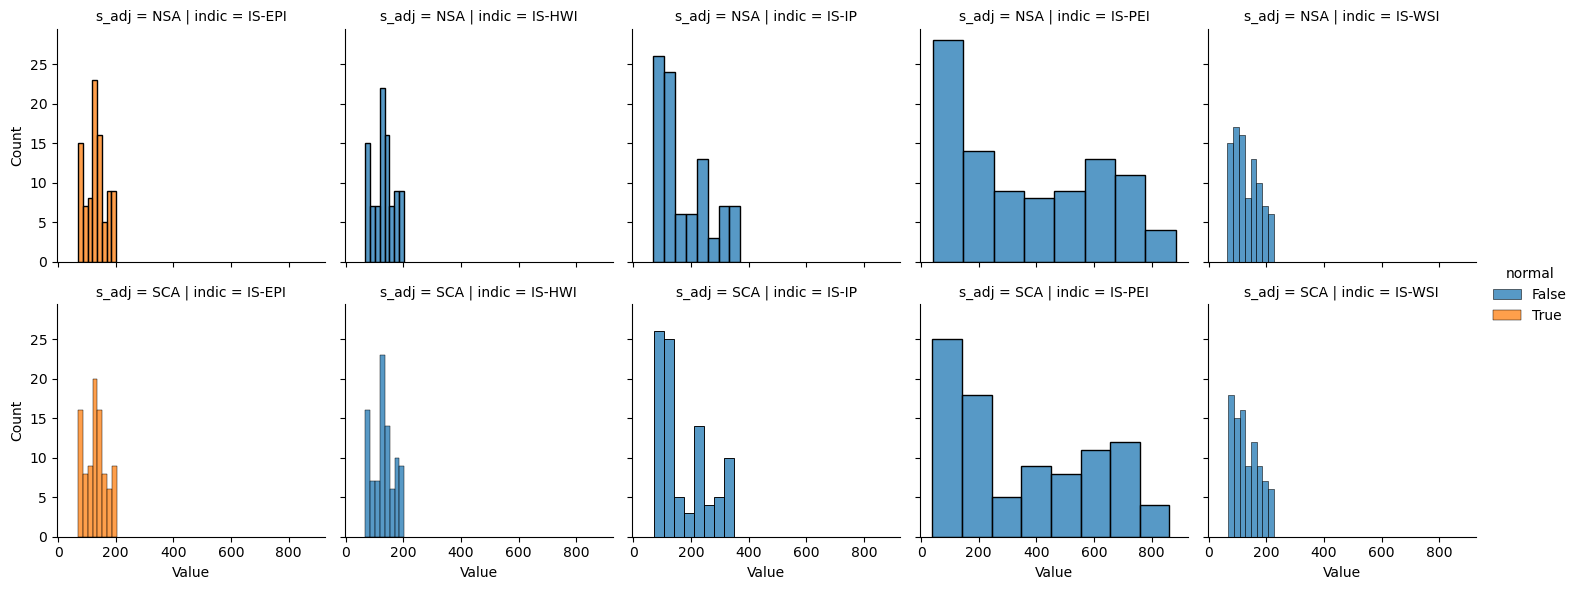

In [328]:
# Create histomgrams of the Value column for the IE dataframe grouped by 'indic' and 's_adj', faceted by the 'normal' column
sns.FacetGrid(df_ie, col='indic', row='s_adj', hue='normal').map(sns.histplot, 'Value').add_legend()

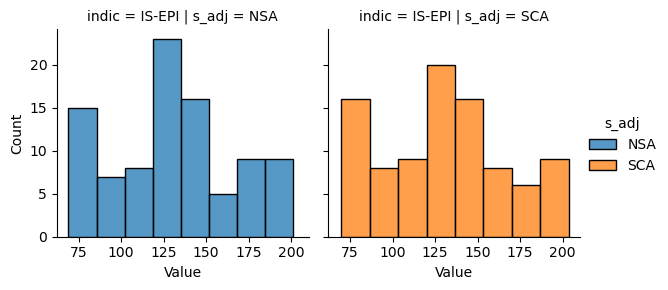

In [329]:
# Create histograms of the Value column for the IE dataframe grouped by 'indic' and 's_adj', where the 'normal' column is True
sns.FacetGrid(df_ie[df_ie['normal'] == True], row='indic', col='s_adj', hue= 's_adj').map(sns.histplot, 'Value').add_legend()

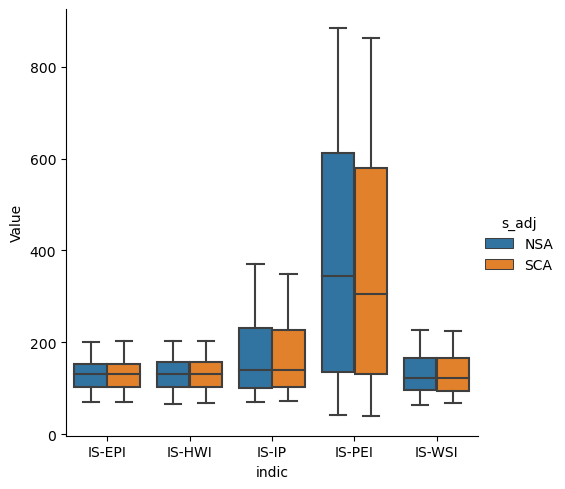

In [330]:
# Visualise the IE dataframe showing statistical analysis using seaborn  and matplotlib  libraries splitting the data by insdicators and seasonanal adjustment
sns.catplot(x="indic", y="Value", hue="s_adj", kind="box", data=df_ie);

Perform Statistical Tests

In [331]:
# return the unique geo\TIME_PERIOD values from the df dataframe, where the indic column equals 'IS-EPI' and the normal column equals True
df[(df['indic'] == 'IS-EPI') & (df['normal'] == True)]['geo\\TIME_PERIOD'].unique()

array(['AT', 'DK', 'EU27_2020', 'EU28', 'FI', 'IE', 'PL', 'SK', 'TR',
       'EL'], dtype=object)

In [332]:
#Compare Ireland with 'EU28' which is the overall EU average for 28 countries

# Create a dataframe called df_ie_eu28 that contains the geo\TIME_PERIOD values of 'IE' and 'EU28'
df_ie_eu28 = df[(df['geo\\TIME_PERIOD'] == 'IE') | (df['geo\\TIME_PERIOD'] == 'EU28')]

In [333]:
# Compare the Number of persons employed index, non-seasonally adjusted, for Ireland and EU28 using a t-test
from scipy.stats import ttest_ind

# Filter the DataFrame to only include rows with geo\TIME_PERIOD values of 'EU28' and 'IE',
# 'IS-EPI' for indic, and 'NSA' for s_adj
df_filtered = df[(df['geo\\TIME_PERIOD'].isin(['EU28', 'IE'])) & (df['indic'] == 'IS-EPI') & (df['s_adj'] == 'NSA')]

# Filter out NaN values from the 'Value' column
df_filtered = df_filtered.dropna(subset=['Value'])

# Split the DataFrame into two separate DataFrames, one for each geo\TIME_PERIOD value
df_eu281 = df_filtered[df_filtered['geo\\TIME_PERIOD'] == 'EU28']
df_ie1 = df_filtered[df_filtered['geo\\TIME_PERIOD'] == 'IE']

# Perform the t-test
t_stat, p_val = ttest_ind(df_eu281['Value'], df_ie1['Value'], equal_var=False)

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")


t-statistic: -5.3129
p-value: 0.0000


In [334]:
# Filter the dataframe to only include rows where the normal column equals True and the indic column equals 'IS-EPI' and the s_adj column equals 'NSA'
df_filtered = df[(df['normal'] == True) & (df['indic'] == 'IS-EPI') & (df['s_adj'] == 'NSA')]

# Filter out NaN values from the 'Value' column
df_filtered = df_filtered.dropna(subset=['Value'])

# Create a list of the unique geo\TIME_PERIOD values
geo_time_periods = df_filtered['geo\\TIME_PERIOD'].unique()

#Make sure the groups have the same sample size
min_sample_size = df_filtered['geo\\TIME_PERIOD'].value_counts().min()
df_filtered = df_filtered.groupby('geo\\TIME_PERIOD').apply(lambda x: x.sample(min_sample_size))

#Perform the ANOVA
f_stat, p_val = f_oneway(*[df_filtered[df_filtered['geo\\TIME_PERIOD'] == geo_time_period]['Value'] for geo_time_period in geo_time_periods])

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")

#Print th resuts of the ANOVA test
if p_val < 0.05:
    print("Reject null hypothesis - Significant differences exist between groups.")
else:
    print("Accept null hypothesis - No significant difference between groups.")

F-statistic: 15.7447
p-value: 0.0000
Reject null hypothesis - Significant differences exist between groups.


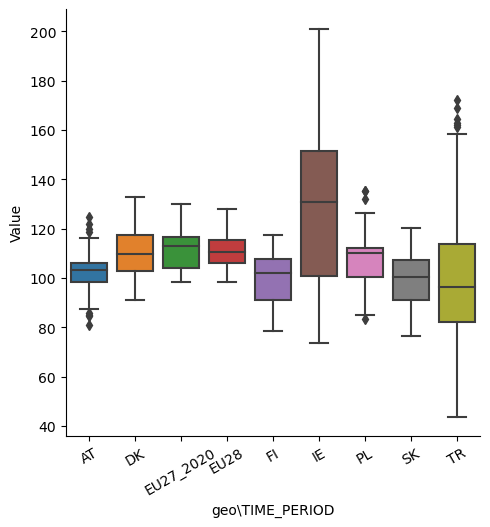

In [335]:
#Show the diferences between the groups using a boxplot with slanted x-axis labels
sns.catplot(x="geo\\TIME_PERIOD", y="Value", kind="box", data=df_filtered).set_xticklabels(rotation=30)

In [336]:
# Perform a Tukey's Range Test to determine which groups are significantly different from each other
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's Range Test
tukey_results = pairwise_tukeyhsd(df_filtered['Value'], df_filtered['geo\\TIME_PERIOD'], 0.05)

# Print the results
print(tukey_results)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj   lower    upper   reject
------------------------------------------------------------
       AT        DK      8.6 0.2246  -2.0284  19.2284  False
       AT EU27_2020   9.9783 0.0853  -0.6501  20.6068  False
       AT      EU28     9.27 0.1444  -1.3584  19.8984  False
       AT        FI  -2.2317 0.9993 -12.8601   8.3968  False
       AT        IE  28.1983    0.0  17.5699  38.8268   True
       AT        PL   6.1133 0.6879  -4.5151  16.7418  False
       AT        SK  -2.5917 0.9978 -13.2201   8.0368  False
       AT        TR   0.4067    1.0 -10.2218  11.0351  False
       DK EU27_2020   1.3783    1.0  -9.2501  12.0068  False
       DK      EU28     0.67    1.0  -9.9584  11.2984  False
       DK        FI -10.8317 0.0419 -21.4601  -0.2032   True
       DK        IE  19.5983    0.0   8.9699  30.2268   True
       DK        PL  -2.4867 0.9984 -13.1151   8.1418  False
       DK        SK -11.

In [337]:
# Create a dataframe called prep1 where the indic column equals 'IS-EPI' and the s_adj column contains 'SCA and 'NSA' values and the normal column equals True
prep1 = df[(df['indic'] == 'IS-EPI') & (df['normal'] == True)]

In [338]:
#Change the name of the geo\TIME_PERIOD column to geo in the df dataframe
prep1.rename(columns={'geo\\TIME_PERIOD': 'geo'}, inplace=True)

C:\Users\Paul\AppData\Local\Temp\ipykernel_28052\690526707.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [339]:
# Perform a TWO-WAY ANOVA to determine if there is an interaction between the geo\TIME_PERIOD and s_adj columns

# Perform two-way ANOVA
model = ols('Value ~ s_adj + geo', data = prep1).fit()
aov2 = sm.stats.anova_lm(model, type=2)
print(aov2)

              df         sum_sq       mean_sq          F        PR(>F)
s_adj        1.0    6537.014341   6537.014341  17.884588  2.487424e-05
geo          9.0  153608.098796  17067.566533  46.695078  1.410451e-74
Residual  1517.0  554480.250606    365.511042        NaN           NaN


In [340]:
# Find countries that have false values for the normal column where the indic column equals 'IS-HWI'
df[(df['normal'] == False) & (df['indic'] == 'IS-HWI')]['geo\\TIME_PERIOD'].unique()

array(['BE', 'BG', 'CY', 'EA19', 'EA20', 'EE', 'ES', 'FI', 'HR', 'IE',
       'IT', 'LT', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PT', 'SE', 'TR',
       'AT', 'DE', 'EL', 'EU28', 'HU', 'LU', 'RO', 'RS', 'SI'],
      dtype=object)

In [341]:
# Filter the data
df_HWI = df[(df['indic'] == 'IS-HWI')]

# Filter out NaN values from the 'Value' column
df_HWI = df_HWI.dropna(subset=['Value'])


In [342]:

# Select the two groups to compare
group1 = df_HWI[df_HWI['geo\\TIME_PERIOD'] == 'IE']['Value']
group2 = df_HWI[df_HWI['geo\\TIME_PERIOD'] == 'EU28']['Value']

# Ensure the two groups have the same sample size
min_sample_size = min(len(group1), len(group2))
group1 = group1.sample(min_sample_size)
group2 = group2.sample(min_sample_size)

# Perform Wilcoxon signed-rank test
stat, p = wilcoxon(group1, group2)

# Print the results
print('Wilcoxon signed-rank test:')
print(f'statistic: {stat:.4f}')
print(f'p-value: {p:.4f}')


Wilcoxon signed-rank test:
statistic: 740.0000
p-value: 0.0000


In [343]:
# Filter the data
df_filtered = df[(df['indic'] == 'IS-HWI') & (df['normal'] == False) & (df['s_adj'] == 'NSA')]

# Filter out NaN values from the 'Value' column
df_filtered = df_filtered.dropna(subset=['Value'])

# Perform Kruskal-Wallis test
stat, p = kruskal(*[df_filtered[df_filtered['geo\\TIME_PERIOD'] == geo]['Value'] for geo in df_filtered['geo\\TIME_PERIOD'].unique()])

# Print the results
print("Kruskal-Wallis Test Results:")
print(f"Test statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")


Kruskal-Wallis Test Results:
Test statistic: 624.6977
P-value: 0.0000


Machine Learning

Sentiment Analysis

In [344]:
# Load from the .env
load_dotenv()

# Get the environmental variables
APP_NAME = getenv('APP_NAME')
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
USERNAME = getenv('REDDIT_USERNAME')
PASSWORD = getenv('PASSWORD')

In [345]:
# Set up reddit API credentials
reddit = praw.Reddit(
    client_id=APP_ID,
    client_secret=APP_SECRET,
    user_agent=APP_NAME,
    username=USERNAME,
    password=PASSWORD,
)

# Define the subreddits and search query
subreddits = ["Ireland", "Europe"]
query = "house prices"

# Collect posts from the subreddits related to the search query
posts = []
for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    for post in subreddit.search(query):
        posts.append(
            {
                "subreddit": subreddit_name,
                "title": post.title,
                "text": post.selftext,
            }
        )

# Convert the collected posts into a dataframe
df_posts = pd.DataFrame(posts)

# Perform sentiment analysis on the collected posts
df_posts["polarity"] = df_posts["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group the results by subreddit and calculate the mean polarity
results = df_posts.groupby("subreddit")["polarity"].mean()

# Print the results
print(results)


subreddit
Europe     0.011886
Ireland    0.012975
Name: polarity, dtype: float64


In [346]:
# Interpret the results of the sentiment analysis
if results["Ireland"] > results["Europe"]:
    print("The sentiment of the posts from r/Ireland is more positive than the sentiment of the posts from r/Europe.")
elif results["Ireland"] < results["Europe"]:
    print("The sentiment of the posts from r/Ireland is more negative than the sentiment of the posts from r/Europe.")
else:
    print("The sentiment of the posts from r/Ireland is the same as the sentiment of the posts from r/Europe.")


The sentiment of the posts from r/Ireland is more positive than the sentiment of the posts from r/Europe.


Machine Learning Model 1

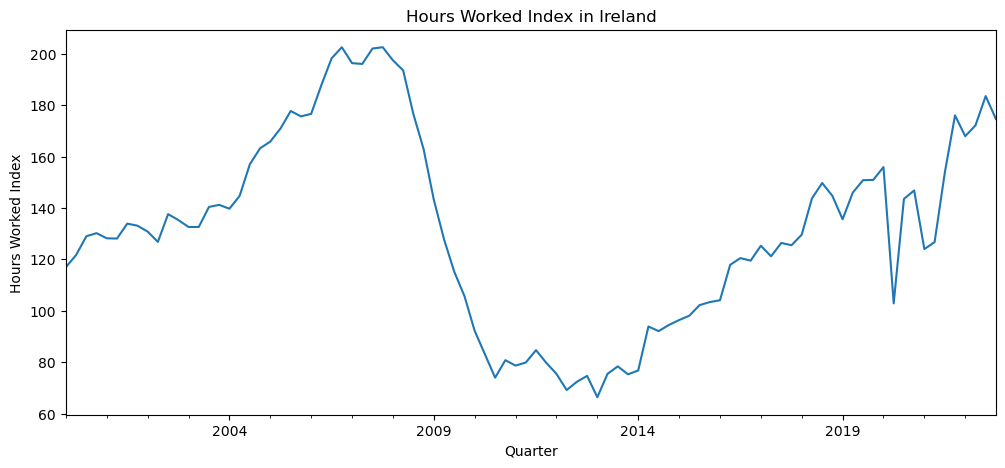

In [361]:
#Time Series Analysis

# Create a dataframe called df_filtered where the indic column equals 'IS-HWI' and the s_adj column contains 'NSA' values and the normal column equals False
df_filtered = df[(df['indic'] == 'IS-HWI') & (df['normal'] == False) & (df['s_adj'] == 'NSA') & (df['geo\\TIME_PERIOD'] == 'IE')]
df_filtered = df_filtered.dropna(subset=['Value'])

from datetime import datetime

# Define a function to parse the date string
def parse_quarter(date_string):
    year, quarter = date_string.split('-Q')
    month = (int(quarter) - 1) * 3 + 1
    return datetime(int(year), month, 1)

#Apply the parse_quarter function to the 'Quarter' column
df_filtered['Quarter'] = df_filtered['Quarter'].apply(parse_quarter)

# Set the 'Quarter' column as the index
df_filtered.set_index('Quarter', inplace=True)

# Create a time series plot of the 'Value' column
df_filtered['Value'].plot(figsize=(12, 5))

# Add a title
plt.title('Hours Worked Index in Ireland')

# Add a y-axis label
plt.ylabel('Hours Worked Index')

# Show the plot
plt.show()

In [363]:
# Perform time series analysis using SARIMAX
model = sm.tsa.statespace.SARIMAX(df_filtered['Value'])
results = model.fit()

# Print the summary statistics
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   92
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -352.252
Date:                Sun, 14 May 2023   AIC                            708.505
Time:                        18:42:17   BIC                            713.548
Sample:                    01-01-2000   HQIC                           710.540
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9973      0.007    134.985      0.000       0.983       1.012
sigma2       117.1209      8.589     13.636      0.000     100.287     133.955
Ljung-Box (L1) (Q):                   0.03   Jarque-

c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [364]:
# Tune the model
model = sm.tsa.statespace.SARIMAX(df_filtered['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
results = model.fit()

# Print the summary statistics
print(results.summary())


c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

c:\Users\Paul\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



                                     SARIMAX Results                                     
Dep. Variable:                             Value   No. Observations:                   92
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -331.689
Date:                           Sun, 14 May 2023   AIC                            673.378
Time:                                   18:42:21   BIC                            685.708
Sample:                               01-01-2000   HQIC                           678.343
                                    - 10-01-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1646      0.763     -0.216      0.829      -1.659       1.330
ma.L1          0.0533      0.769      0.069

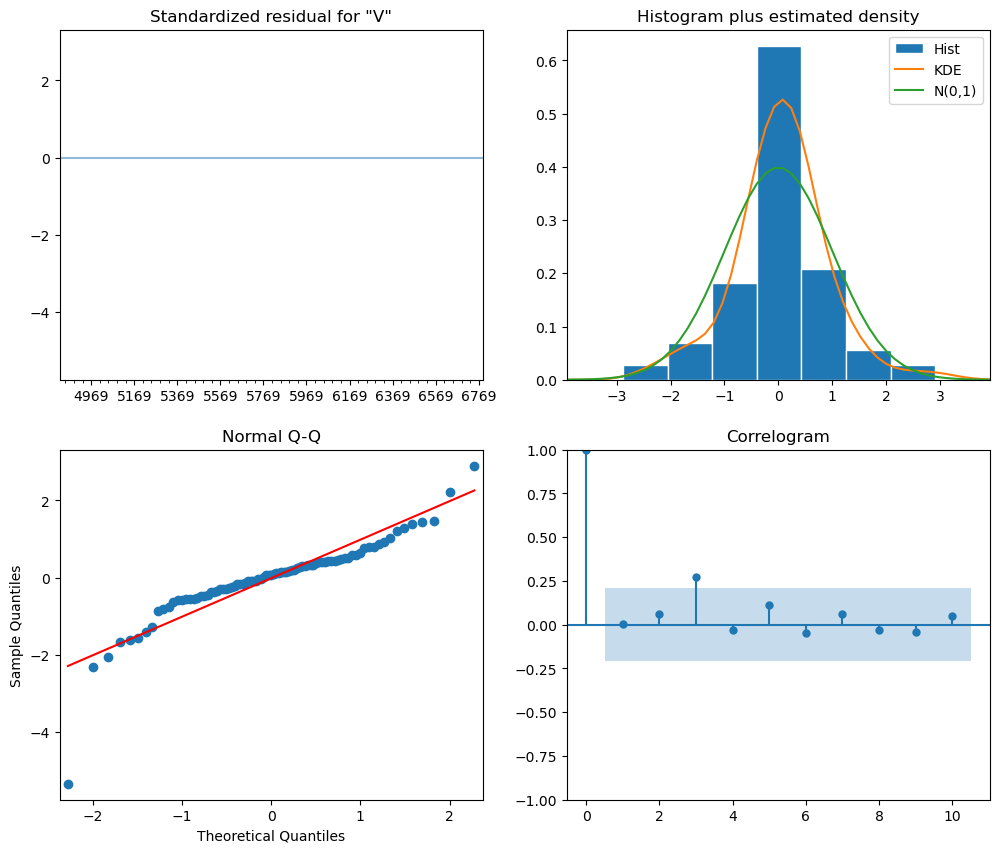

In [365]:
# Visualize the results
results.plot_diagnostics(figsize=(12, 10))
plt.show()

Machine Learning Model 2

Support Vector Regression

In [382]:
# Filter the data
df_drop = df.dropna(subset=['Value'])
df_drop = df_drop[(df_drop['indic'] == 'IS-EPI')]

# Scale the 'Value' column
df_drop['Value'] = StandardScaler().fit_transform(df_drop[['Value']])

# select the relevant columns as features and target
X = df_drop[['geo\\TIME_PERIOD', 's_adj']]
y = df_drop['Value']

# perform one-hot encoding on the categorical columns
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

# create and fit the model
model = SVR()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# calculate the model's performance metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared:", r2)



MSE: 0.7063431043174441
R-squared: 0.318966510406282


In [384]:
# create a Support Vector Regression object
svr = SVR()

# define the hyperparameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}

# create a GridSearchCV object
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# print the best hyperparameters found
print(grid_search.best_params_)


{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}


In [385]:
# Use the best hyperparameters to create a new model
best_svr = SVR(C=100, gamma=0.1, kernel='linear')

# Fit the model to the training data
best_svr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svr.predict(X_test)

# Calculate the model's performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared:", r2)

MSE: 0.6794321837401246
R-squared: 0.34491316159736474
